Importing Libraries

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Loading the Dataset

In [89]:
data = pd.read_csv('dataset.csv')

data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     337 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                328 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Q1. Identify missing or incorrect data in the dataset and apply appropriate preprocessing steps to clean it

In [91]:
missing_data = data.isnull().sum()

print(missing_data)

species               0
island                0
bill_length_mm        7
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  16
dtype: int64


In [92]:
list(data.columns)

['species',
 'island',
 'bill_length_mm',
 'bill_depth_mm',
 'flipper_length_mm',
 'body_mass_g',
 'sex']

Outliers in bill_length_mm: 0 rows
Outliers in bill_depth_mm: 0 rows
Outliers in flipper_length_mm: 0 rows
Outliers in body_mass_g: 3 rows


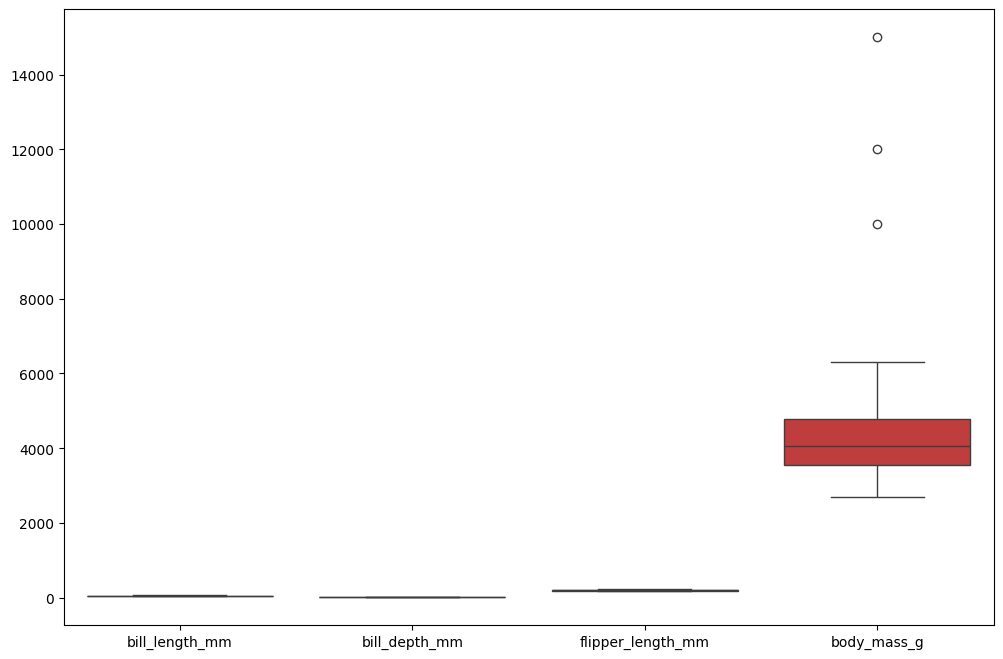

In [93]:
#Identify outliers using IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

outliers_info = {}

for feature in ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    outliers = detect_outliers(data, feature)
    outliers_info[feature] = len(outliers)
    print(f"Outliers in {feature}: {len(outliers)} rows")

# Visualize outliers with boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']])
plt.show()

In [94]:
outliers_info

{'bill_length_mm': 0,
 'bill_depth_mm': 0,
 'flipper_length_mm': 0,
 'body_mass_g': 3}

- Steps followed to handle missing data
    - For categorical variables in this case `sex` feature :
        - The common approach is to replace the missing values with the `mode` of that column but here I have used KNN to find the best suitable category depending upon the other features because replacing with `mode` will result by replacing all the missing values with `Male` which would not be a better approach. Therefore by using `KNN` we could handle the missing values more efficiently.
    - For numercial features:
        - The common approach is to either perform `mean` imputation or `median` imputation.
        - Here what this code does is that first it checks for the outliers for each feature then if there are outliers present then we go for `median` imputation otherwise we go for `mean` imputation. Because `median` imputation is more robust to the outliers.

In [108]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

for column, dtype in zip(data.columns, data.dtypes):
    if dtype == 'object' and column == 'sex':
        features = data.drop(columns=["sex", "species", "island"])
        target = data["sex"]

        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(features[target.notnull()], target[target.notnull()])

        missing_indices = target[target.isnull()].index
        predicted_sex = knn.predict(features.loc[missing_indices])

        data.loc[missing_indices, "sex"] = predicted_sex
        data.head()
    if dtype != 'object':
        if column in outliers_info.keys() and outliers_info[column] != 0:  # if there are outliers present for a feature then we replace the missing value by median. 
            data[column] = data[column].fillna(data[column].median())
        else:                                                              # if there are no outliers present for a feature then we replace the missing values by mean.
            data[column] = data[column].fillna(data[column].mean())

In [109]:
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100000,18.70000,181.000000,3750.0,male
1,Adelie,Torgersen,39.500000,17.40000,186.000000,3800.0,female
2,Adelie,Torgersen,40.300000,18.00000,195.000000,3250.0,female
3,Adelie,Torgersen,43.876855,17.15117,200.915205,4050.0,male
4,Adelie,Torgersen,36.700000,19.30000,193.000000,3450.0,female
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.800000,19.80000,207.000000,4000.0,male
340,Chinstrap,Dream,43.500000,18.10000,202.000000,3400.0,female
341,Chinstrap,Dream,49.600000,18.20000,193.000000,3775.0,male
342,Chinstrap,Dream,50.800000,19.00000,210.000000,4100.0,male


Q2. What is the average body_mass_g for Gentoo penguins?

In [98]:
gentoo_penguins = data[data['species'] == 'Gentoo']
gentoo_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
152,Gentoo,Biscoe,46.100000,13.20000,211.000000,4500.0,female
153,Gentoo,Biscoe,50.000000,16.30000,230.000000,5700.0,male
154,Gentoo,Biscoe,48.700000,14.10000,210.000000,4450.0,female
155,Gentoo,Biscoe,50.000000,15.20000,218.000000,5700.0,male
156,Gentoo,Biscoe,47.600000,14.50000,215.000000,5400.0,male
...,...,...,...,...,...,...,...
271,Gentoo,Biscoe,43.876855,17.15117,200.915205,4050.0,NaN
272,Gentoo,Biscoe,46.800000,14.30000,215.000000,4850.0,female
273,Gentoo,Biscoe,50.400000,15.70000,222.000000,5750.0,male
274,Gentoo,Biscoe,45.200000,14.80000,212.000000,5200.0,female


In [99]:
avg_mass_gentoo = gentoo_penguins['body_mass_g'].mean()

print(f'Average body_mass_g for Gentoo Pengius is {avg_mass_gentoo}g')

Average body_mass_g for Gentoo Pengius is 5125.0g


Q3. How do the distributions of bill_length_mm and bill_depth_mm differ between the three penguin species? Analyze the skewness and kurtosis of each feature for different species.

C:\Users\Pranav\AppData\Local\Temp\ipykernel_12072\26766871.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='species', y='bill_length_mm', data=data, palette=species_colors)
C:\Users\Pranav\AppData\Local\Temp\ipykernel_12072\26766871.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='species', y='bill_depth_mm', data=data, palette=species_colors)


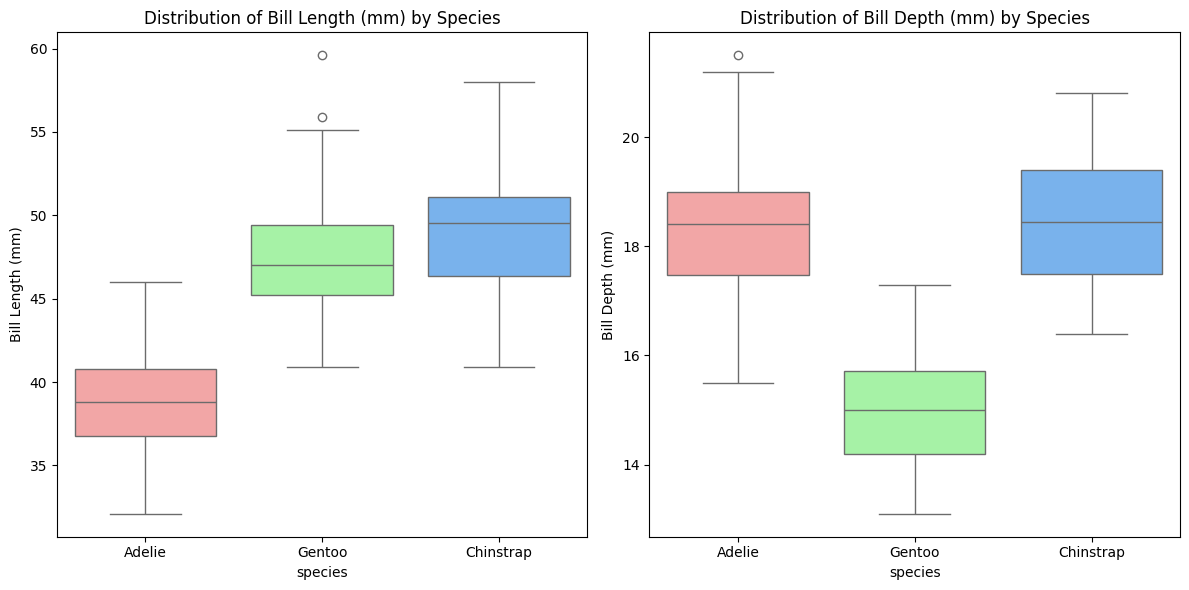

In [100]:
plt.figure(figsize=(12, 6))

species_colors = {'Adelie': '#FF9999', 'Chinstrap': '#66B2FF', 'Gentoo': '#99FF99'}

# Subplot for bill length distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='species', y='bill_length_mm', data=data, palette=species_colors)
plt.title('Distribution of Bill Length (mm) by Species')
plt.ylabel('Bill Length (mm)')

# Subplot for bill depth distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='species', y='bill_depth_mm', data=data, palette=species_colors)
plt.title('Distribution of Bill Depth (mm) by Species')
plt.ylabel('Bill Depth (mm)')

plt.tight_layout()
plt.show()


From the above plots we can observe the following :

- Bill Length: There are clear differences in the median bill lengths between the species. For example:
    - Chinstrap penguins have the longest bills on average.
    - Gentoo penguins have intermediate bill lengths.
    - Adelie penguins have the shortest bills.

- Bill Depth: The bill depth distribution also varies between species:
    - Adelie penguins have intermediate bill depths, with a median between Gentoo and Chinstrap, but a lot closer to Chinstrap.
    - Gentoo penguins generally have the shallowest bills 

- Overall Observations:
    - There's a clear separation between species in both bill length and depth, suggesting these measurements could be useful for species identification.
    - Chinstrap penguins tend to have longer and deeper bills compared to the other species.
    - Adelie penguins have short but relatively deep bills.
    - Gentoo penguins have medium-length bills but the shallowest depth.
    - There are some outliers present, particularly for bill length in Gentoo and Chinstrap species.

In [101]:
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.100000,18.70000,181.000000,3750.0,male
1,Adelie,Torgersen,39.500000,17.40000,186.000000,3800.0,female
2,Adelie,Torgersen,40.300000,18.00000,195.000000,3250.0,female
3,Adelie,Torgersen,43.876855,17.15117,200.915205,4050.0,NaN
4,Adelie,Torgersen,36.700000,19.30000,193.000000,3450.0,female
...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.800000,19.80000,207.000000,4000.0,male
340,Chinstrap,Dream,43.500000,18.10000,202.000000,3400.0,female
341,Chinstrap,Dream,49.600000,18.20000,193.000000,3775.0,male
342,Chinstrap,Dream,50.800000,19.00000,210.000000,4100.0,male


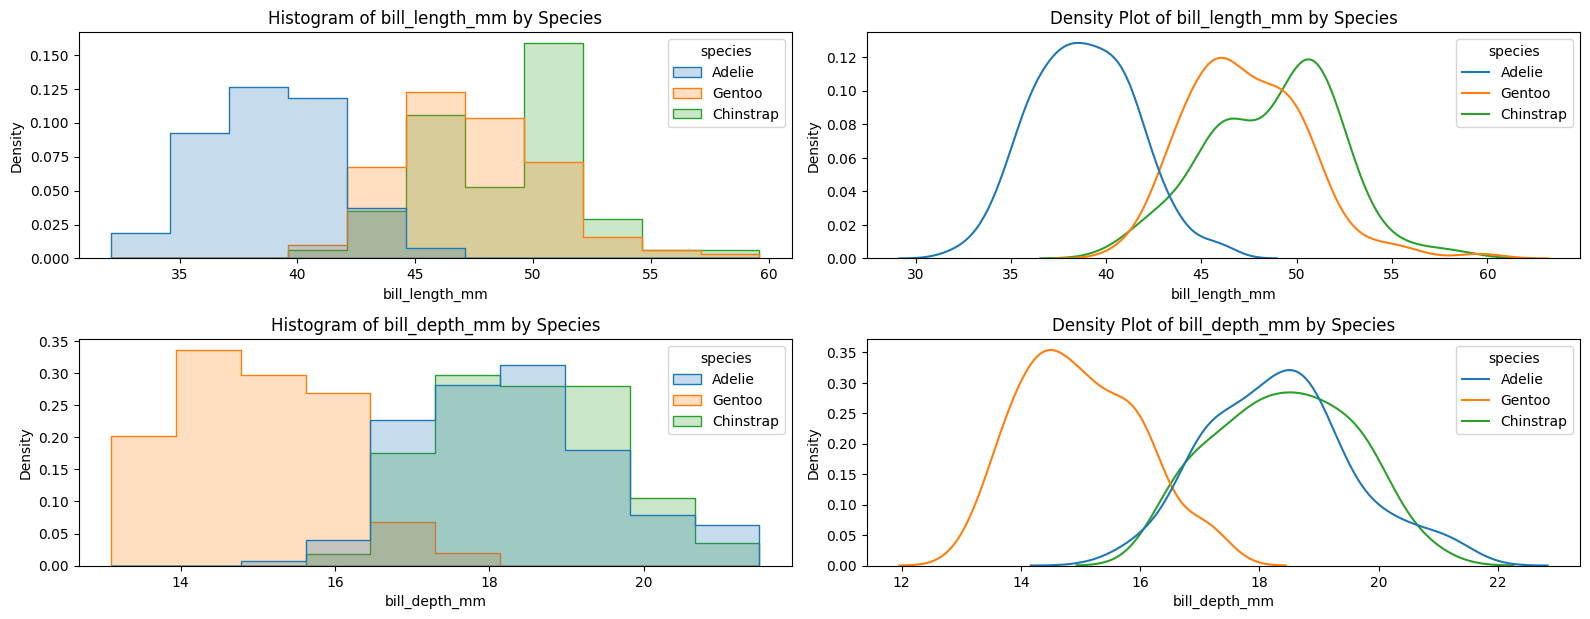

In [112]:
from scipy.stats import skew, kurtosis

numerical_cols = ['bill_length_mm', 'bill_depth_mm']

# Set the figure size
plt.figure(figsize=(16, 12))

# Plot histograms and density plots for each numerical feature grouped by species
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, 2*i+1)
    sns.histplot(data=data, x=col, hue='species', kde=False, element="step", stat="density", common_norm=False)
    plt.title(f'Histogram of {col} by Species')

    plt.subplot(4, 2, 2*i+2)
    sns.kdeplot(data=data, x=col, hue='species', common_norm=False)
    plt.title(f'Density Plot of {col} by Species')

plt.tight_layout()
plt.show()


In [113]:
from scipy.stats import skew, kurtosis

grouped_df = data.groupby('species')

def calculate_skewness_kurtosis(group):
    return pd.DataFrame({
        'Skewness': group.apply(skew),
        'Kurtosis': group.apply(kurtosis)
    })

features = ['bill_length_mm', 'bill_depth_mm']
skewness_kurtosis_df = grouped_df[features].apply(calculate_skewness_kurtosis).unstack()

skewness_kurtosis_df

Skewness                     Kurtosis              
          bill_length_mm bill_depth_mm bill_length_mm bill_depth_mm
species                                                            
Adelie          0.162533      0.329209      -0.228104     -0.101072
Chinstrap      -0.095936      0.006726      -0.124011     -0.898740
Gentoo          0.712323      0.334623       1.147647     -0.611126

- Skewness Analysis:
    - Bill Length:
        - Adelie (0.16) and Gentoo (0.71) show positive skewness, indicating a longer tail on the right side. This means most penguins in these species have shorter bill lengths, with a few having much longer bills.
        - Chinstrap (-0.09) has a slight negative skew, suggesting a longer tail on the left side, but this skewness is minimal and can be interpreted as close to symmetrical.

    - Bill Depth:
        - All species have slight positive skewness (close to 0), indicating fairly symmetric distributions for bill depth across species.

- Key Takeaways on Skewness:
    - Bill length is moderately right-skewed for Adelie and Gentoo, meaning a majority of these penguins have shorter bills, while a few have much longer ones.

- Kurtosis Analysis:
    - Bill Length:
        - Adelie (-0.23) and Chinstrap (-0.12) show slightly negative kurtosis, which means these distributions have lighter tails compared to a normal distribution (fewer extreme values).
        - Gentoo (1.15) shows positive kurtosis, indicating heavier tails, implying more outliers in bill length distribution compared to the other species.

    - Bill Depth:
        - Gentoo (-0.61) and Chinstrap (-0.90) show negative kurtosis, meaning their bill depth distributions have lighter tails, with fewer outliers.
        - Adelie (-0.10) is close to normal distribution but still leans towards lighter tails.

- Key Takeaways on Kurtosis:
    - Gentoo shows heavier tails (outliers) in bill length compared to the other species.

Q4. Identify which features in the dataset have outliers. Provide the method used to detect them and visualize the outliers.

Outliers in bill_length_mm: 0 rows
Outliers in bill_depth_mm: 0 rows
Outliers in flipper_length_mm: 0 rows
Outliers in body_mass_g: 3 rows


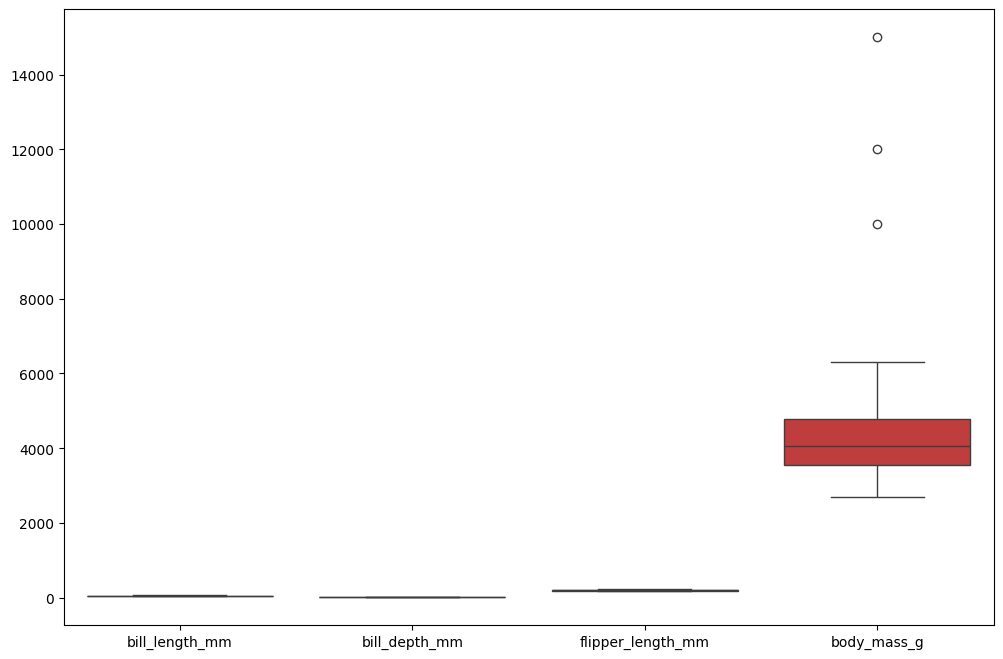

In [115]:
#Identify outliers using IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

outliers_info = {}

for feature in ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']:
    outliers = detect_outliers(data, feature)
    outliers_info[feature] = len(outliers)
    print(f"Outliers in {feature}: {len(outliers)} rows")

# Visualize outliers with boxplots
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']])
plt.show()

- In this analysis, I employed the Interquartile Range (IQR) method to detect outliers in the dataset features. The IQR is a measure of statistical dispersion calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1). Outliers are defined as observations that fall below Q1−1.5×IQR or above Q3+1.5×IQR, indicating that these values are significantly different from the majority of the data.
- To visualize the outliers, I used a box plot, which displays the median, quartiles, and any potential outliers, allowing for a clear understanding of the data distribution.

Q5. Does this dataset contribute to the curse of dimensionality? If yes perform PCA.

- In this case as the number of features are very less, so it is unlikely that it suffers from curse of dimensionality.
- But we can perform PCA which would help us in better visualisation.

In [141]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def get_components_for_variance(data, target_variance=0.96):
    # Step 1: Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Step 2: Apply PCA without specifying the number of components
    pca = PCA()
    pca.fit(data_scaled)

    # Step 3: Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Step 4: Find the number of components that explain the target variance
    num_components = np.argmax(cumulative_variance >= target_variance) + 1

    print(f"Number of components to retain {target_variance*100}% variance: {num_components}")
    return num_components

# Assuming 'data' is your pandas DataFrame with numerical features
df = data.drop(columns=["species", "island"])
numerical_data = df.select_dtypes(include=[np.number])
n_components = get_components_for_variance(numerical_data)

Number of components to retain 96.0% variance: 4


C:\Users\Pranav\AppData\Local\Temp\ipykernel_12072\614402769.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('Set1')


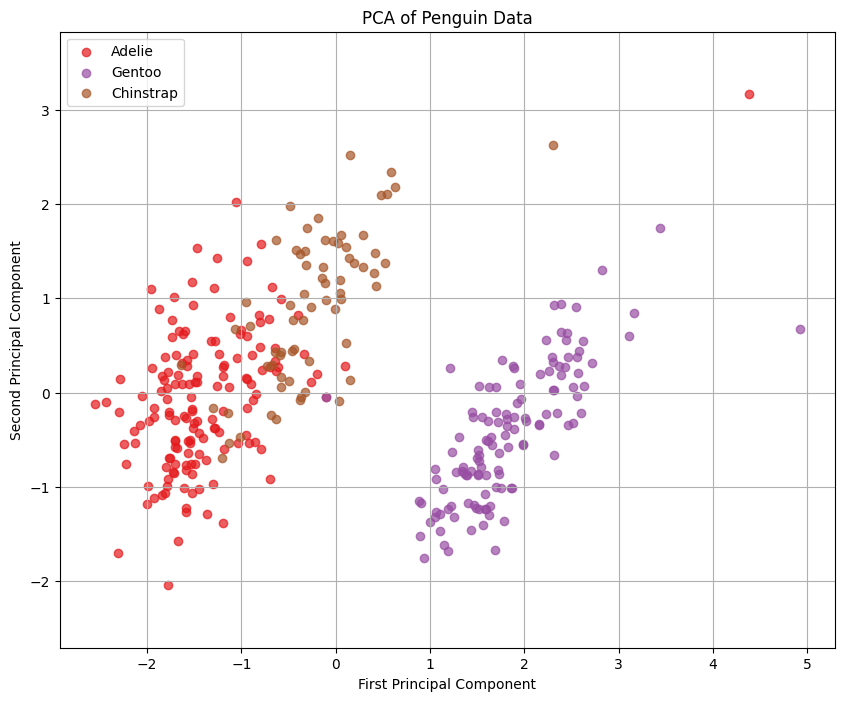

In [124]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

numerical_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

X = data[numerical_cols].dropna()  # Drop any missing values for PCA

# Standardize the data
X_standardized = (X - X.mean()) / X.std()

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['species'] = data['species']

plt.figure(figsize=(10, 8))

species = pca_df['species'].unique()
color_map = plt.cm.get_cmap('Set1')
colors = {species[i]: color_map(i/len(species)) for i in range(len(species))}

for species in pca_df['species'].unique():
    subset = pca_df[pca_df['species'] == species]
    plt.scatter(subset['PC1'], subset['PC2'], c=[colors[species]], label=species, alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Penguin Data')
plt.legend()

plt.grid(True)
plt.axis('equal')
plt.show()

Q6. Use bill_length_mm vs bill_depth_mm and plot 7 different graphs to visualize them.

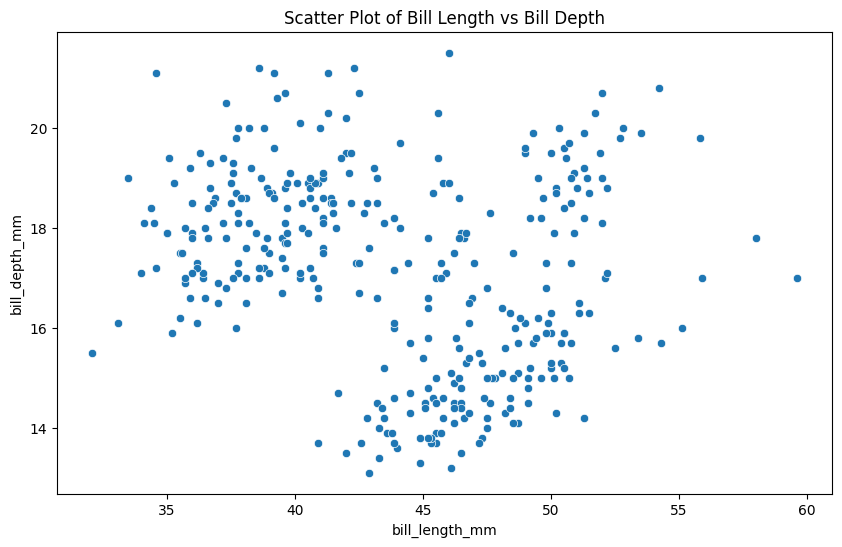

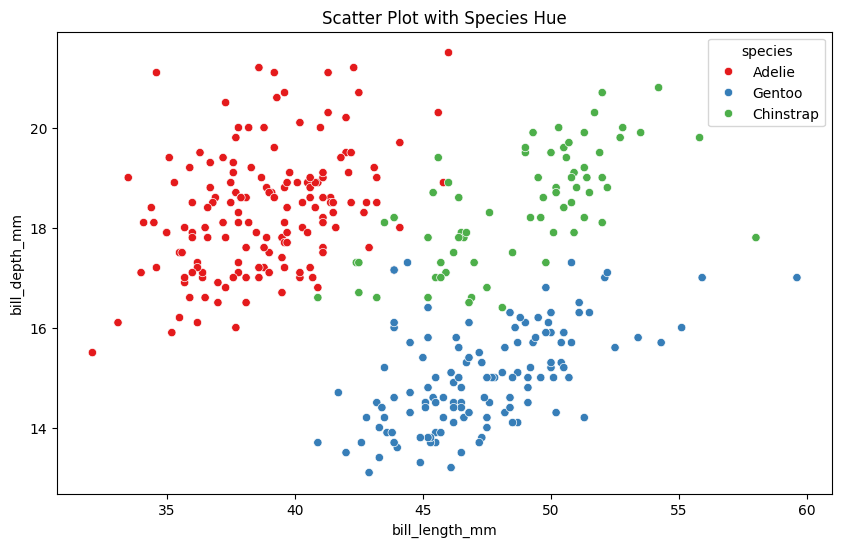

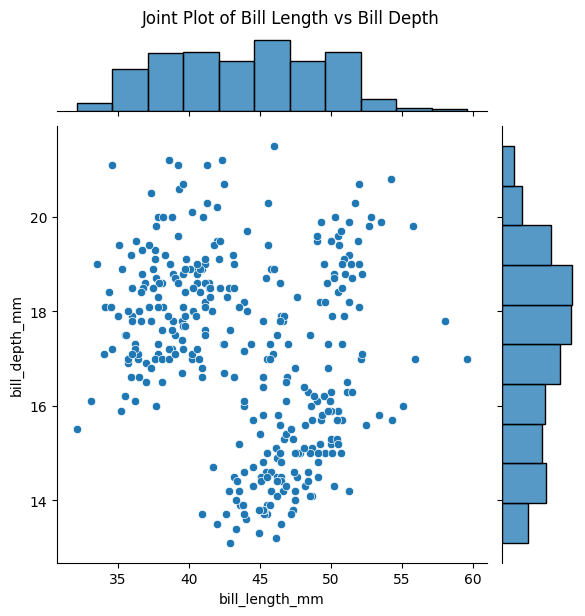

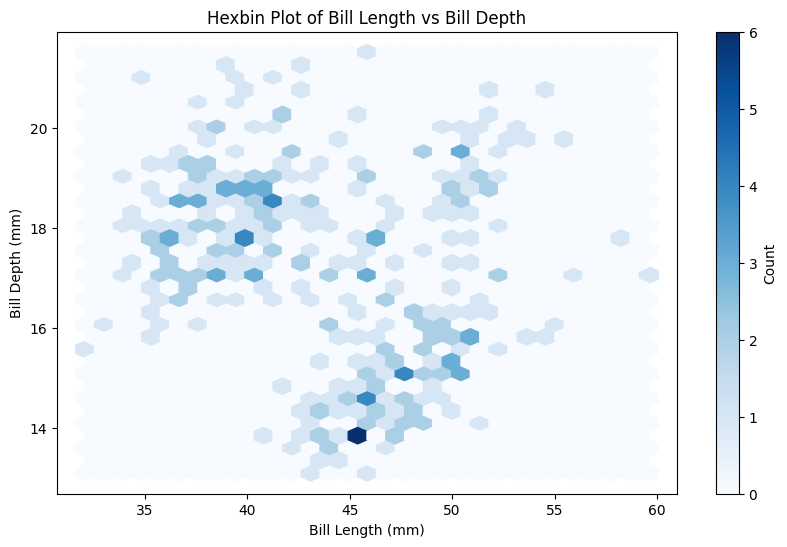

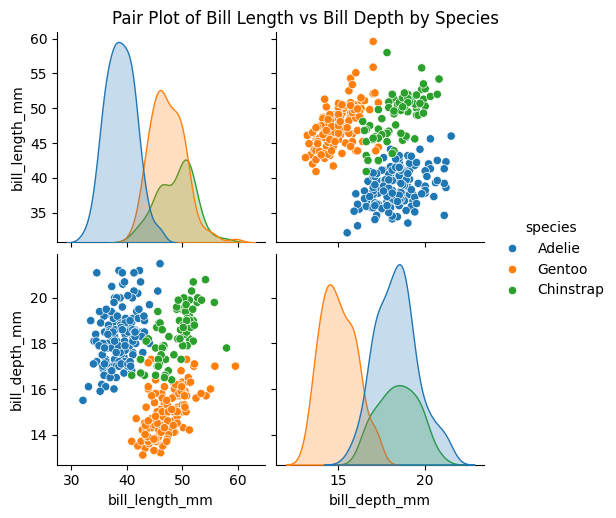

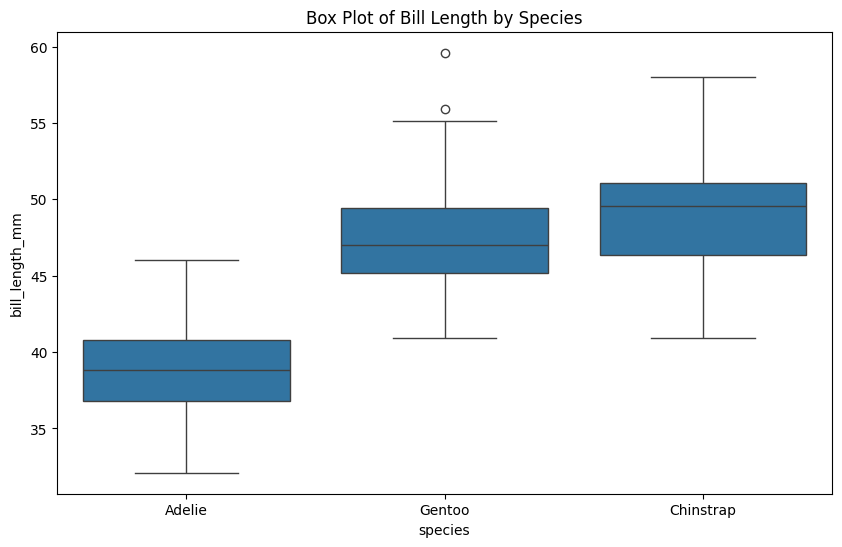

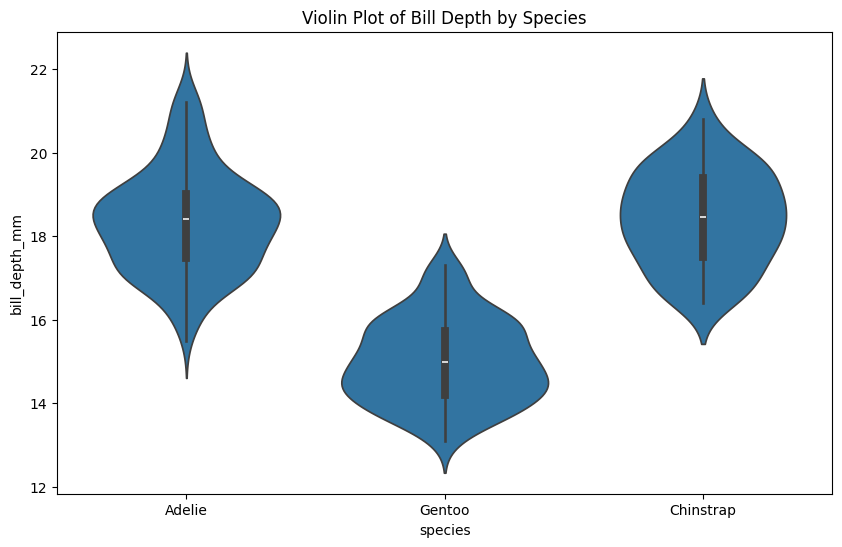

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot: bill_length_mm vs bill_depth_mm
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', data=data)
plt.title('Scatter Plot of Bill Length vs Bill Depth')
plt.show()

# Scatter plot with species hue
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', hue='species', data=data, palette='Set1')
plt.title('Scatter Plot with Species Hue')
plt.show()

# Joint plot (combination of scatter plot with histograms)
sns.jointplot(x='bill_length_mm', y='bill_depth_mm', data=data, kind='scatter')
plt.suptitle('Joint Plot of Bill Length vs Bill Depth', y=1.02)
plt.show()

# Hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(data['bill_length_mm'], data['bill_depth_mm'], gridsize=30, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Hexbin Plot of Bill Length vs Bill Depth')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Bill Depth (mm)')
plt.show()

# Pair plot (this can be used with more features but we'll just focus on bill_length and bill_depth)
sns.pairplot(data, hue='species', vars=['bill_length_mm', 'bill_depth_mm'])
plt.suptitle('Pair Plot of Bill Length vs Bill Depth by Species', y=1.02)
plt.show()

# Box plot for bill_length_mm by species
plt.figure(figsize=(10, 6))
sns.boxplot(x='species', y='bill_length_mm', data=data)
plt.title('Box Plot of Bill Length by Species')
plt.show()

# Violin plot for bill_depth_mm by species
plt.figure(figsize=(10, 6))
sns.violinplot(x='species', y='bill_depth_mm', data=data)
plt.title('Violin Plot of Bill Depth by Species')
plt.show()

Q7. Find the maximum flipper_length_mm for each combination of species and island. Which species has the longest flippers on each island?

In [134]:
flipperLength = data.groupby(['species', 'island'])['flipper_length_mm'].max().reset_index()

flipperLength

,species,island,flipper_length_mm
0,Adelie,Biscoe,203.0
1,Adelie,Dream,208.0
2,Adelie,Torgersen,210.0
3,Chinstrap,Dream,212.0
4,Gentoo,Biscoe,231.0


In [135]:
longestFlippers = flipperLength.loc[flipperLength.groupby('island')['flipper_length_mm'].idxmax()]

longestFlippers

,species,island,flipper_length_mm
4,Gentoo,Biscoe,231.0
3,Chinstrap,Dream,212.0
2,Adelie,Torgersen,210.0


Q8. Perform z-score normalization on this dataset.

In [136]:
from sklearn.preprocessing import StandardScaler

numerical_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

scaler = StandardScaler()

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

print(data.head())


  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen       -0.882230       0.787743          -1.422488   
1  Adelie  Torgersen       -0.808355       0.126556          -1.065352   
2  Adelie  Torgersen       -0.660604       0.431719          -0.422507   
3  Adelie  Torgersen        0.000000       0.000000           0.000000   
4  Adelie  Torgersen       -1.325483       1.092905          -0.565361   

   body_mass_g     sex  
0    -0.468990    male  
1    -0.424125  female  
2    -0.917634  female  
3    -0.199803    male  
4    -0.738176  female  
